# COVID19

In the previous assignment you have developed a particle based simulation of disease spreading. One infected individual was infecting other individuals when meeting them. The individuals were then recovering after a certain time of being infected and becoming immune to further infections. We now have a look at a model of disease spreading, which describes the same problem in terms of three coupled differential equations. This is the Kermack-McKendrick Model.

In [242]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.sparse import diags
from scipy.integrate import odeint
import requests
import io
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

plt.rcParams.update({'font.size': 12,
                     'axes.titlesize': 18,
                     'axes.labelsize': 16,
                     'axes.labelpad': 14,
                     'lines.linewidth': 1,
                     'lines.markersize': 10,
                     'xtick.labelsize' : 16,
                     'ytick.labelsize' : 16,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in',}) 

## The Kermack-McKendrick Model

The Kermack-McKendrick model (KM) was an early compartmental model. It divides the population into three groups: Susceptible (S), Infected (I), and Removed (R\). These are often referred to as **SIR** models. In the simple model below, there is, however, no population removed by death or so, but we will implement the removal as well.

Kermack and McKendrick built their model to deepen their understanding of epidemics where an infected individual enters into a population and suddenly begins spreading the disease. They assumed that the population remains constant (apart from deaths which are represented by the R term in the model), so ignore any effects from birth, non-disease related death, migration in or out of the target area. Moreover, all of the individuals are equally susceptible, so no bonus points for those who are healthier or have better hygiene habits in this model. All of these are limitations of the model, but also make it a great starting point for epidemiology studies. 

### Model Equation

The differential equations of the model are simple rate equations for the susceptibel $x$, the infected $y$ and the recovered $z$ population. There are two rate constants in the model, one for getting infected $k_{I}$ and one for recovering $k_{R}$.
If you look at the equations below, you see that the number of people removed from the suceptible population per timestep is just the infection rate times the number of people that can be infected $x$ times the number of people who is infected. That seems to be clear as none can be infected if there none to infect and none the can infect others.

\begin{equation}
\dot{x}=-k_{I}xy
\end{equation}

\begin{equation}
\dot{y}=k_{I}xy-k_{R}y
\end{equation}

\begin{equation}
    \dot{z}=k_{R}y
\end{equation}



## Setup

Here we define again our initial parameters and the initial conditions. We would like to run the simulation for 

* $n=1000$ people 
* $i=1$ infected people at the beginning
* $N=1000$ timesteps of the simulation

We chose the individual rates the following way

* $k_I=0.001$ the rate of infection
* $k_R=0.1$ the rate of recovery
* $k_D=0.05$ the rate of death, if we include death as well

These rates are just guesses (well I tried earlier), but you might want to map the earlier particle based simulation onto this model to compare the dynamics observed both.

In [321]:
n=1000 # total people
i=1 # infected people
state=[n-i,i,0] # initial state
N=100

t=np.linspace(0,100,N)

## Definition

Our `covid19` function now implements the differential equations above into a function. This is rather straight forward, as they are only first order differential euqations.

In [326]:
def covid19(state , time):
    k_I=0.001 ## infection rate
    k_R=0.1 ## recovery rate 
    k_D=0.01 ## death rate
    g0 = -k_I*state[0]*state[1]
    g1 = k_I*state[0]*state[1]-k_R*state[1] - k_D*state[1]
    g2 = k_R*state[1]
    return(np.array([g0, g1, g2]) )

## Solution

The following code solves the coupled differential equations and sorts the solution into individual arrays for further plotting.

In [327]:
answer = odeint( covid19, state , t ) 

susceptible=answer[:,0]
infected=answer[:,1]
recovered=answer[:,2]
dead=n-np.sum(answer[:,:],axis=1)

## Plotting

We can now plot the solution of the model. You see that after some delay, the number of infected people quickly increases until the recovery sets in. Then the number of infected people decreases again until all are recovered. You may change the above rate of death now to see how it effects the diagram. You can now play around and check out what happens if you increase the recovery or infection rate. 

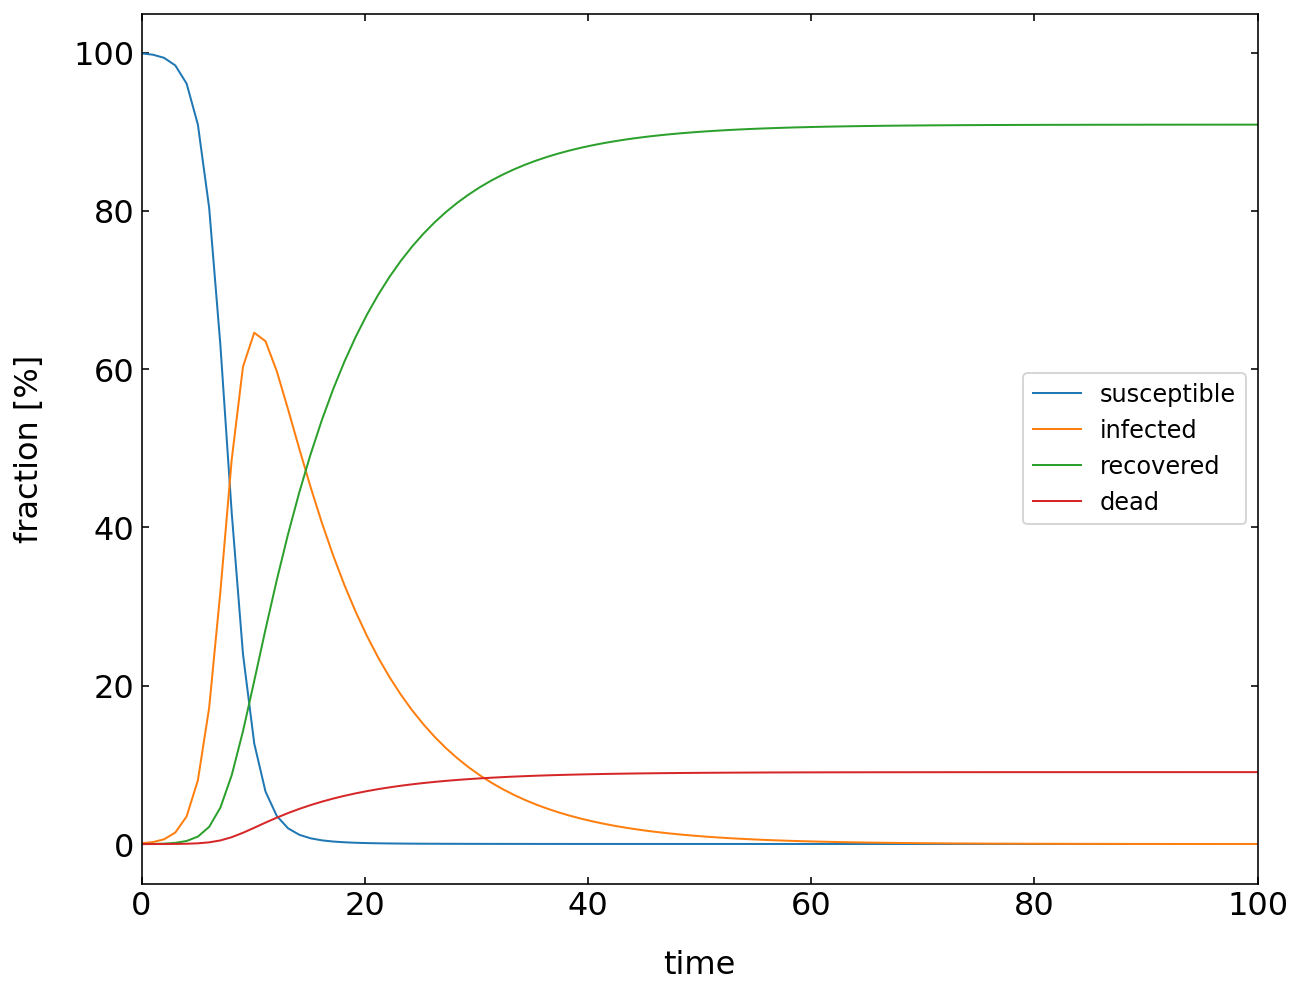

In [328]:
percent=100/n
plt.figure(figsize=(10,8))
plt.plot(t,susceptible*percent,label='susceptible')
plt.plot(t,infected*percent,label='infected')
plt.plot(t,recovered*percent,label='recovered')
plt.plot(t,dead*percent,label='dead')
plt.xlabel('time')
plt.ylabel('fraction [%]')
plt.legend()
plt.xlim(0,100)
plt.show()

## Real COVID19 numbers

To compare the behavior to the current pandemic, I have downloaded some the current data for 5 different countries and stored them in the `covid19.csv` file. The data file reports
**Date**, **Country**, **Confirmed**, **Recovered** and **Deaths**. To make the data comparable, I have already normalized the cases to the population of the country and multiplied by 1 million.
That means the data is showsing the number of cases per million.

In [330]:
cut=pd.read_csv('covid19.csv')

### Total number of cases

To analyze the current situation we want to plot the total number of cases. To make the data more comparable, we do the following calculations. We first normalize the number of cases to the total population of the country. I have done that already in the dataset as mentioned above. The second issue is, that one should compare the data of different countries, when the total number of cases per million inhabitants crosses one for example. That is the only useful way to compare data. Note that this is a cummulative number. 

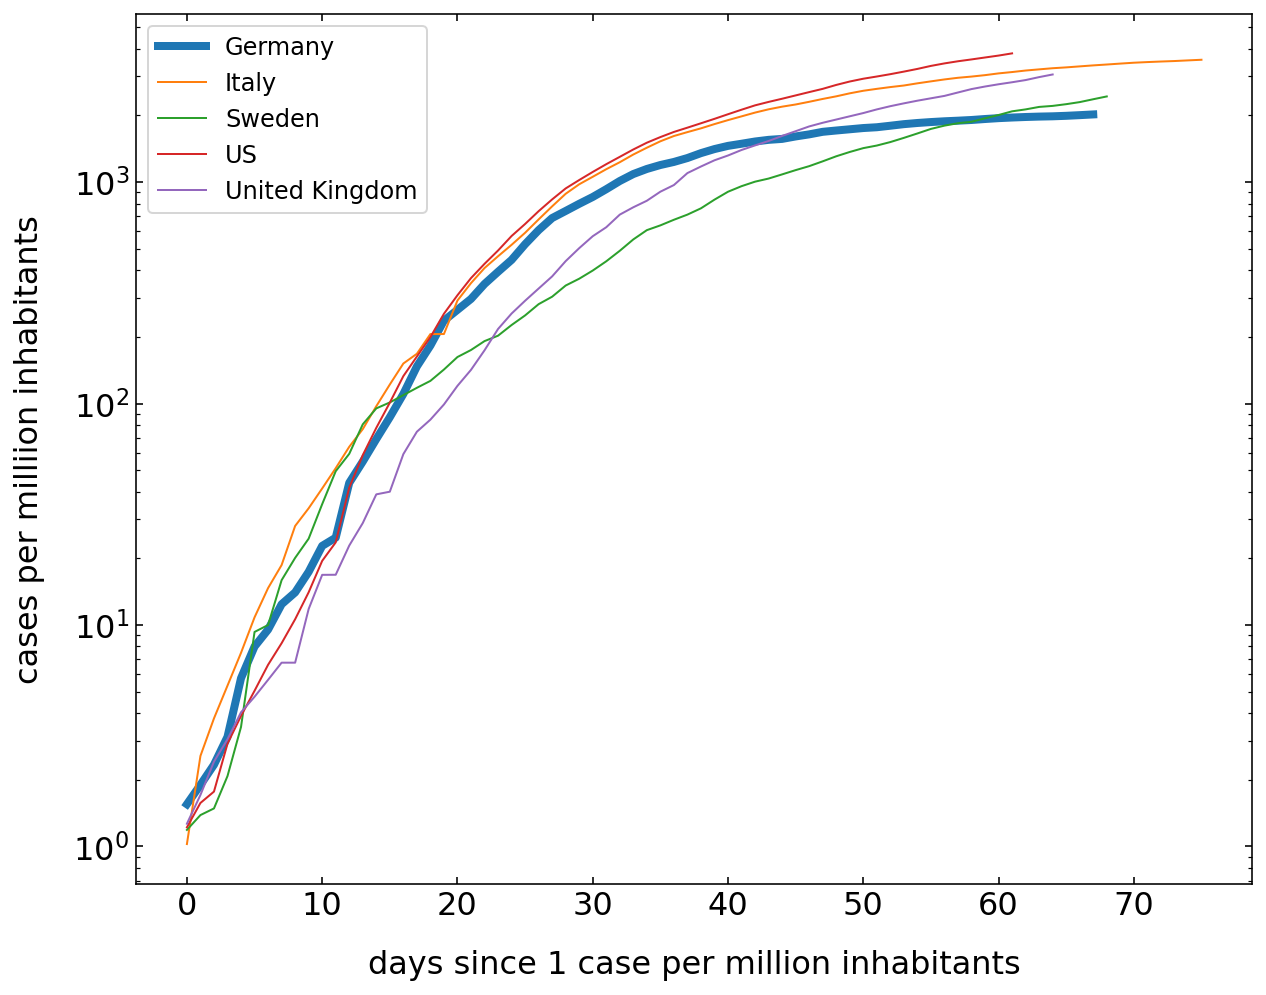

In [331]:
plt.figure(figsize=(10,8))
for c in cut.Country.unique():
    df=cut[cut.Country==c]
    cases=df[df.Confirmed>1].Confirmed.values
    if c=='Germany':
        lw=4
    else:
        lw=1
    plt.semilogy(cases,label=c,lw=lw);
 
plt.legend()
plt.xlabel('days since 1 case per million inhabitants')
plt.ylabel('cases per milliion inhabitants')
plt.show()

### Number of Deaths

The graph below does the same analysis as the one for the confimed cases, but only for the number of death. While the differences in the cummulative numbers of confirmed cases are small, the number of death per million in the countries show already some differences in the total death. Yet the kinetics is still similar.

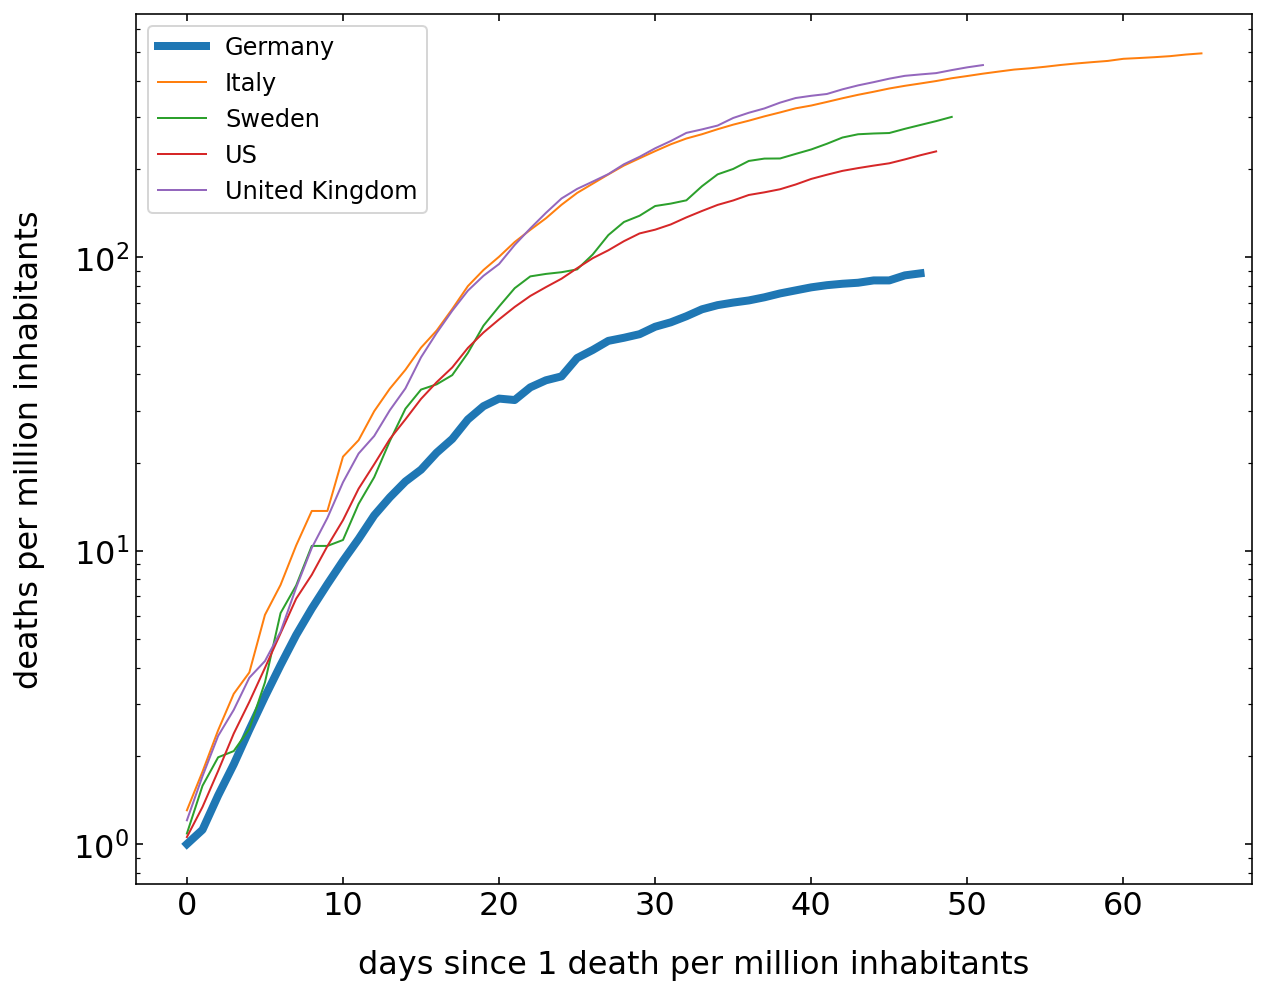

In [332]:
plt.figure(figsize=(10,8))
for c in cut.Country.unique():
    df=cut[cut.Country==c]
    cases=df[df.Deaths>1].Deaths.values
    if c=='Germany':
        lw=4
    else:
        lw=1
    plt.semilogy(cases,label=c,lw=lw);

plt.legend()
plt.xlabel('days since 1 death per million inhabitants')
plt.ylabel('deaths per million inhabitants')
plt.show()
    

### New cases per day

The next plot is comparing the new cases that appear per million people each day. Have a look at how this is done with the help of pandas. The data would be rather "noisy" as this is just the derivative of the confirmed cases curve. To smooth that out, I have included a rolling average. This rolling average takes the average of 5 following days and the moves one day forward each time. You may recognize the different dynamics in the countries 

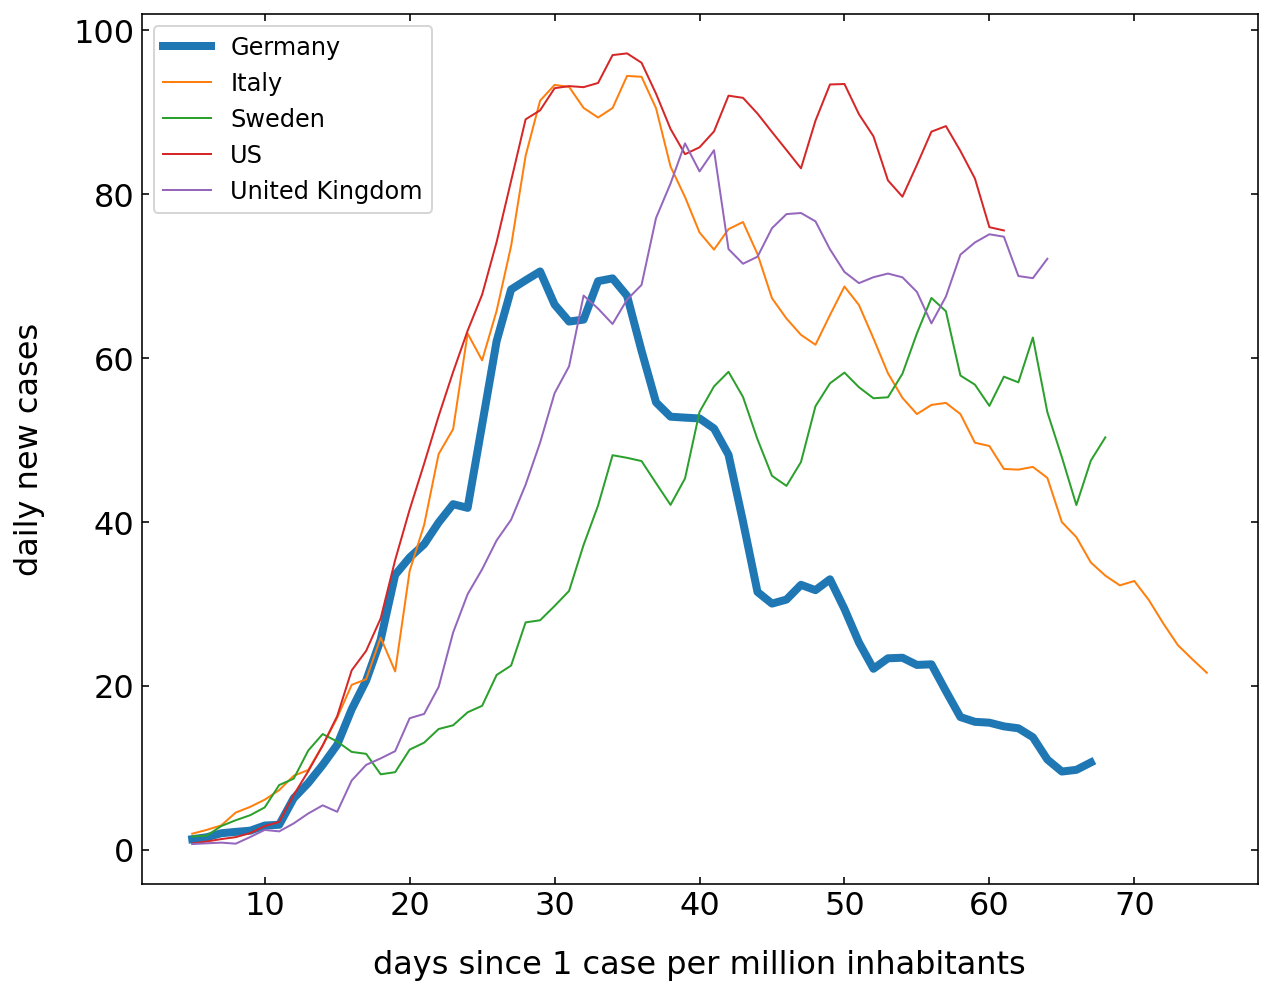

In [333]:
plt.figure(figsize=(10,8))
for c in cut.Country.unique():
    df=cut[cut.Country==c]
    cases=df[df.Confirmed>1].Confirmed
    new_cases=cases.diff(1).rolling(5).mean()
    if c=='Germany':
        lw=4
    else:
        lw=1    
    #plt.plot(cases.diff().values,label=c);
    plt.plot(new_cases.values,label=c,lw=lw)

plt.legend()
plt.xlabel('days since 1 case per million inhabitants')
plt.ylabel('daily new cases')
plt.show()

### Current cases

The last plot is the number of current active cases. This can be calculated from the total number of cases when we subtract the recovered and the death. This curve should roughly correspond in its shape to the model above. Think about, how the model is different from the real data.

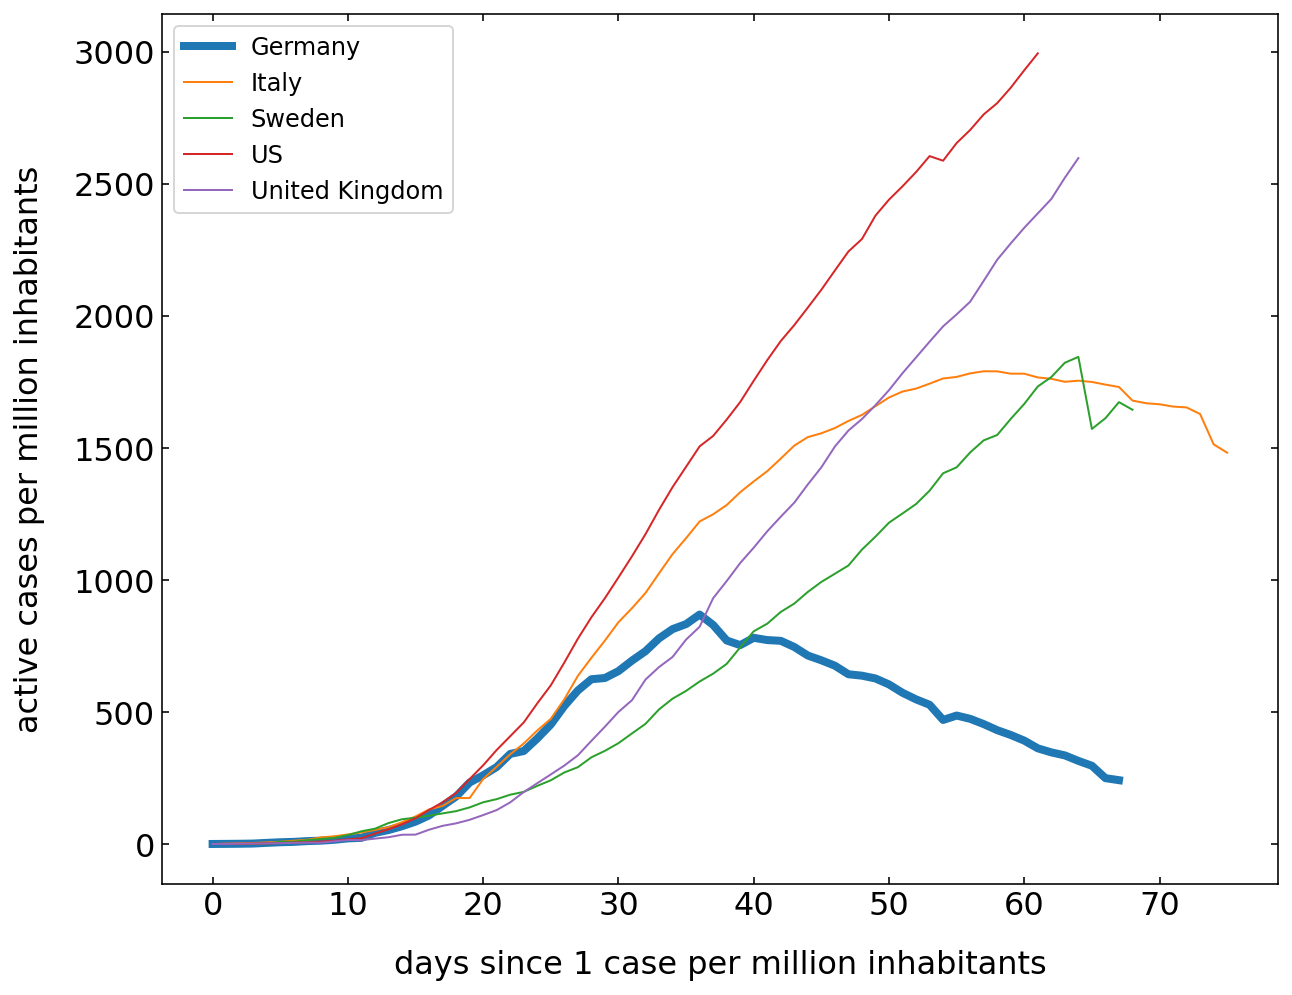

In [334]:
plt.figure(figsize=(10,8))
for c in cut.Country.unique():
    df=cut[cut.Country==c]
    cases=df[df.Confirmed>1].Confirmed.values-df[df.Confirmed>1].Recovered.values-df[df.Confirmed>1].Deaths.values
    if c=='Germany':
        lw=4
    else:
        lw=1
    plt.plot(cases,label=c,lw=lw);

plt.legend()
plt.xlabel('days since 1 case per million inhabitants')
plt.ylabel('active cases per million inhabitants')
plt.show()